### Explore how good feature selection affect RMSE of log(price)

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import category_encoders as ce
import pandas as pd
import subprocess
import pprint as pp
import warnings
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import sklearn

%matplotlib inline
PATH='../data/'


In [109]:
class RemovingFeatures(TransformerMixin):
    """
    removing feature missing to many values
    """
    def __init__(self, cols_removing):
        self.cols_removing = cols_removing

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.cols_removing, axis=1)


class PoolQCTransformer(TransformerMixin):
    """
    transform PoolQC column
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        map_poolqc = {"PoolQC": {"Ex": 3, "Gd": 2, "Fa": 1, np.nan: 0}}
        return X.replace(map_poolqc)


class PoolAreaTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {"PoolArea": 0}
        return X.fillna(value=values)


class GrLivAreaTransformer(TransformerMixin):
    """
    perform log transformation of GrLivArea col because it is right-skewed in
    both train and test set
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['GrLivArea'] = np.log1p(X['GrLivArea'])  # log1p(x) more accurate for small x
        return X


class MSSubClassTransformer(TransformerMixin):
    """
    one-hot encoded this feature because it is categorical
    instead of recognize it as an int feature
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        col = 'MSSubClass'
        dummy = pd.get_dummies(X[col], prefix=col)
        drop_col = X.drop(col, axis=1)
        df = pd.concat([dummy, drop_col], axis=1)
        return df


class RemodAfterAdding(TransformerMixin):
    """
    add column RemodAfter = YearRemodAdd - YearBuilt
    YearBuilt and YearRemodAdd has no missing values
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['RemodAfter'] = X['YearRemodAdd'] - X['YearBuilt']
        return X
    
class GarageTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        impute num features with 0
        impute categorical features with NA
        """
        num_cols = ['GarageYrBlt', 'GarageCars', 'GarageArea']
        cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X[num_cols] = (X[num_cols]).fillna(0)
        X[cat_cols] = (X[cat_cols]).fillna('NA')
        return X
    
class LotFrontageTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {"LotFrontage": 0}
        return X.fillna(value=values)
    
class MasVnrTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {"MasVnrArea": 0.0, "MasVnrType": 'None'}
        return X.fillna(value=values)
    
class ElectricalTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {'Electrical': 'SBrkr'}
        return X.fillna(value=values)
    
class BasementTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {
            'BsmtQual': 'NA',
            'BsmtCond': 'NA',
            'BsmtExposure': 'NA',
            'BsmtFinType1': 'NA',
            'BsmtFinType2': 'NA',
        }
        return X.fillna(value=values)

In [49]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [140]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats

def get_train_val(train):
    X = train.iloc[:, 0:-1]
    y = train.iloc[:, -1]  # label SalePrice, last column
    return train_test_split(X, y, test_size=0.3, random_state=42)

def run_baseline_pool(train, test, encoder):
    cols_removing = ['Id', 'Alley', 'MiscFeature', 'Fence', 'FireplaceQu']
    pipe = Pipeline([
        ('dropping', RemovingFeatures(cols_removing)),
        ('PoolQC', PoolQCTransformer()),
        ('PoolArea', PoolAreaTransformer()),
        ('GrLivArea', GrLivAreaTransformer()),
        ('garage features', GarageTransformer()),
        ('impute LotFrontage 0', LotFrontageTransformer()),
        ('impute MasVnr type and area', MasVnrTransformer()),
        ('impute Electrical - most frequent', ElectricalTransformer()),
        ('impute basement features', BasementTransformer()),
        ('encoder', encoder),
#         ('scaler', StandardScaler()),
        ('reg', XGBRegressor(),
    ])
    # remove outliers
    filter_not_outlier = np.abs(stats.zscore(train['GrLivArea'])) < 2.5
    train = train[filter_not_outlier]

    X_train, X_val, y_train, y_val = get_train_val(train)
    print('X_train', X_train.shape)
    
    pipe.fit(X=X_train, y=y_train)
    val_pred = pipe.predict(X_val)
    mse = mean_squared_error(np.log(y_val), np.log(val_pred))
    rmse = np.sqrt(mse)
    print("validation RMSE:", rmse)
    return pipe

warnings.filterwarnings('ignore')
encoder_sklearn = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
encoder_ce = ce.OneHotEncoder(handle_unknown='ignore')
pipe = run_baseline_pool(train, test, encoder_ce)
regtuple = pipe.steps[-1] # the last step in pipe is tuple ('name', model)
model = regtuple[1] # 2nd element in the tuple is the model
print("number of features in feature_importances_")
print(len(model.feature_importances_))

X_train (1005, 80)
validation RMSE: 0.12104290157593357
number of features in feature_importances_
274


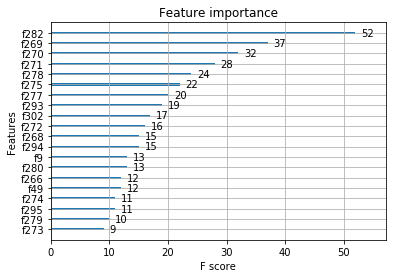

In [7]:
from xgboost import plot_importance

plot_importance(model, max_num_features=20)

In [ ]:
# feature names


In [76]:
# num features
cols_removing = ['Id', 'Alley', 'MiscFeature', 'Fence', 'FireplaceQu']
pipe = Pipeline([
    ('dropping', RemovingFeatures(cols_removing)),
    ('PoolQC', PoolQCTransformer()),
    ('PoolArea', PoolAreaTransformer()),
    ('GrLivArea', GrLivAreaTransformer()),
])
X_train, X_val, y_train, y_val = get_train_val(train)
transformed = pipe.fit_transform(X_train)
print("number of features before one-hot-encoding")
print(len(transformed.columns))
num_features = transformed.columns

# cat features - number of features after onehotencoding
enc = ce.OneHotEncoder(handle_unknown='ignore')
pipe = Pipeline([
    ('dropping', RemovingFeatures(cols_removing)),
    ('PoolQC', PoolQCTransformer()),
    ('PoolArea', PoolAreaTransformer()),
    ('GrLivArea', GrLivAreaTransformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', enc),
    ('scaler', StandardScaler())
])
X_train, X_val, y_train, y_val = get_train_val(train)
transformed = pipe.fit_transform(X_train)
print("number of features after one-hot-encoding")
print(transformed.shape)
print("number of cat cols transformed by OneHotEncoder")
print(len(enc.cols))

model = XGBRegressor()
model.fit(transformed, y_train)
print("number of elements in feature_importances_", len(model.feature_importances_))

number of features before one-hot-encoding
75
number of features after one-hot-encoding
(1022, 266)
number of cat cols transformed by OneHotEncoder
38
number of elements in feature_importances_ 266


In [80]:
enc.category_mapping

[{'col': 1,
  'mapping': [('RL', 1), ('RM', 2), ('FV', 3), ('C (all)', 4), ('RH', 5)]},
 {'col': 4, 'mapping': [('Pave', 1), ('Grvl', 2)]},
 {'col': 5, 'mapping': [('Reg', 1), ('IR1', 2), ('IR2', 3), ('IR3', 4)]},
 {'col': 6, 'mapping': [('Lvl', 1), ('HLS', 2), ('Bnk', 3), ('Low', 4)]},
 {'col': 7, 'mapping': [('AllPub', 1), ('NoSeWa', 2)]},
 {'col': 8,
  'mapping': [('Inside', 1),
   ('Corner', 2),
   ('CulDSac', 3),
   ('FR2', 4),
   ('FR3', 5)]},
 {'col': 9, 'mapping': [('Gtl', 1), ('Mod', 2), ('Sev', 3)]},
 {'col': 10,
  'mapping': [('NWAmes', 1),
   ('Edwards', 2),
   ('Somerst', 3),
   ('CollgCr', 4),
   ('NAmes', 5),
   ('SawyerW', 6),
   ('Sawyer', 7),
   ('Gilbert', 8),
   ('OldTown', 9),
   ('BrkSide', 10),
   ('SWISU', 11),
   ('ClearCr', 12),
   ('StoneBr', 13),
   ('Crawfor', 14),
   ('Mitchel', 15),
   ('NoRidge', 16),
   ('Blmngtn', 17),
   ('Veenker', 18),
   ('Timber', 19),
   ('IDOTRR', 20),
   ('NridgHt', 21),
   ('BrDale', 22),
   ('MeadowV', 23),
   ('NPkVill', 24)

In [83]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
pipe = Pipeline([
    ('dropping', RemovingFeatures(cols_removing)),
    ('PoolQC', PoolQCTransformer()),
    ('PoolArea', PoolAreaTransformer()),
    ('GrLivArea', GrLivAreaTransformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', enc),
    ('scaler', StandardScaler())
])
X_train, X_val, y_train, y_val = get_train_val(train)
transformed = pipe.fit_transform(X_train)
print("number of features after one-hot-encoding")
print(transformed.shape)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [15]:
encoder

OneHotEncoder(cols=[2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 58, 61, 62, 63, 74, 75],
       drop_invariant=False, handle_unknown='impute', impute_missing=True,
       return_df=True, use_cat_names=False, verbose=0)

In [17]:
transformed.columns[encoder.cols]

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [20]:
encoder.category_mapping

[{'col': 2,
  'mapping': [('RL', 1), ('RM', 2), ('FV', 3), ('C (all)', 4), ('RH', 5)]},
 {'col': 5, 'mapping': [('Pave', 1), ('Grvl', 2)]},
 {'col': 6, 'mapping': [('Reg', 1), ('IR1', 2), ('IR2', 3), ('IR3', 4)]},
 {'col': 7, 'mapping': [('Lvl', 1), ('HLS', 2), ('Bnk', 3), ('Low', 4)]},
 {'col': 8, 'mapping': [('AllPub', 1), ('NoSeWa', 2)]},
 {'col': 9,
  'mapping': [('Inside', 1),
   ('Corner', 2),
   ('CulDSac', 3),
   ('FR2', 4),
   ('FR3', 5)]},
 {'col': 10, 'mapping': [('Gtl', 1), ('Mod', 2), ('Sev', 3)]},
 {'col': 11,
  'mapping': [('NWAmes', 1),
   ('Edwards', 2),
   ('Somerst', 3),
   ('CollgCr', 4),
   ('NAmes', 5),
   ('SawyerW', 6),
   ('Sawyer', 7),
   ('Gilbert', 8),
   ('OldTown', 9),
   ('BrkSide', 10),
   ('SWISU', 11),
   ('ClearCr', 12),
   ('StoneBr', 13),
   ('Crawfor', 14),
   ('Mitchel', 15),
   ('NoRidge', 16),
   ('Blmngtn', 17),
   ('Veenker', 18),
   ('Timber', 19),
   ('IDOTRR', 20),
   ('NridgHt', 21),
   ('BrDale', 22),
   ('MeadowV', 23),
   ('NPkVill', 24

In [21]:
transformed.MSZoning.value_counts()

RL         807
RM         155
FV          43
RH          13
C (all)      4
Name: MSZoning, dtype: int64

In [27]:
# if not specify handle_unknown='ignore', encoder will create automatically an extra col
# to contain the category -1 (which is the missing value in the original col)
enc = ce.OneHotEncoder(handle_unknown='ignore')
df_encoded = enc.fit_transform(transformed)

In [28]:
df_encoded.columns

Index(['MSZoning_1', 'MSZoning_2', 'MSZoning_3', 'MSZoning_4', 'MSZoning_5',
       'Street_1', 'Street_2', 'LotShape_1', 'LotShape_2', 'LotShape_3',
       ...
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object', length=278)

## sklearn OneHotEncoder

In [84]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [85]:
X

[['Male', 1], ['Female', 3], ['Female', 2]]

In [87]:
enc.get_feature_names()

array(['x0_Female', 'x0_Male', 'x1_1', 'x1_2', 'x1_3'], dtype=object)

In [88]:
type(enc.get_feature_names())

numpy.ndarray

In [89]:
enc.get_feature_names().tolist()

['x0_Female', 'x0_Male', 'x1_1', 'x1_2', 'x1_3']

## apply sklearn OneHotEncoder to train df

In [128]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

cols_removing = ['Id', 'Alley', 'MiscFeature', 'Fence', 'FireplaceQu']
pipe = Pipeline([
    ('dropping', RemovingFeatures(cols_removing)),
    ('PoolQC', PoolQCTransformer()),
    ('PoolArea', PoolAreaTransformer()),
    ('GrLivArea', GrLivAreaTransformer()),
    ('garage features', GarageTransformer()),
    ('impute LotFrontage 0', LotFrontageTransformer()),
    ('impute MasVnr type and area', MasVnrTransformer()),
    ('impute Electrical - most frequent', ElectricalTransformer()),
    ('impute basement features', BasementTransformer()),
])
X_train, X_val, y_train, y_val = get_train_val(train)
transformed = pipe.fit_transform(X_train)

# missing values
print("number of missing values")
null_sum = transformed.isnull().sum()
print(len(null_sum[null_sum > 0]))

# 38 cat_features
cat_features = transformed.columns[transformed.dtypes == 'object'].tolist()
print('number of cat features', len(cat_features))

number of missing values
0
number of cat features 38


In [134]:
# ohe
mask_cat_features = (transformed.dtypes == 'object')
enc = OneHotEncoder(handle_unknown='ignore', categorical_features=mask_cat_features)
enc.fit(transformed)
len(enc.get_feature_names())

ValueError: could not convert string to float: 'RL'

In [136]:
sklearn.__version__

'0.20.1'

In [ ]:
# ohe
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(transformed)
len(enc.get_feature_names())

model = XGBRegressor()
model.fit(transformed, y_train)
print("number of elements in feature_importances_", len(model.feature_importances_))

val_pred = model.predict(X_val)
mse = mean_squared_error(np.log(y_val), np.log(val_pred))
rmse = np.sqrt(mse)
print("validation RMSE:", rmse)